In [1]:
! pip install transformers accelerate einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 16.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 771.9/771.9 kB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 60.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import torch
from transformers import InstructBlipForConditionalGeneration, InstructBlipProcessor # install from git repo

model = InstructBlipForConditionalGeneration.from_pretrained(
	"Salesforce/instructblip-vicuna-7b",
	load_in_4bit=False,
	torch_dtype=torch.bfloat16
	)

processor = InstructBlipProcessor.from_pretrained(
	"Salesforce/instructblip-vicuna-7b")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
import torch

torch.cuda.empty_cache()

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = model.to(device)

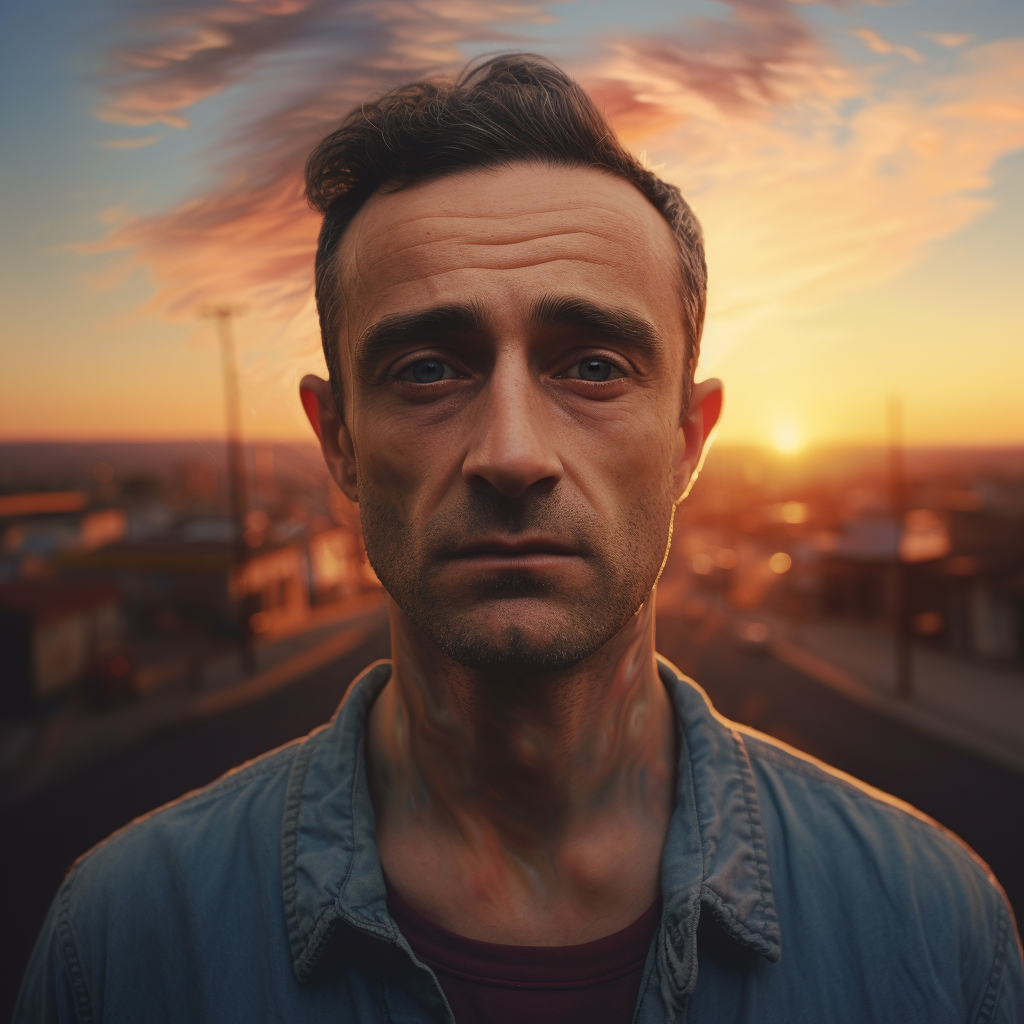

In [5]:
from PIL import Image
from IPython.display import display

image = Image.open("test.png")

display(image)

In [6]:
prompt1 = "describe this image in full detail. describe each and every aspect of the image so that an artist can recreate this image."
prompt2 = "create an extensive description of this image"

answers = []
for _prompt in [prompt1, prompt2]:
    inputs = processor(images=image, 
                        text=_prompt, 
                        return_tensors="pt"
                    ).to(model.device, torch.bfloat16)
    outputs = model.generate(
            **inputs, 
            do_sample=False,
            num_beams=10,
            max_length=512,
            min_length=16,
            top_p=0.9,
            repetition_penalty=1.5,
            temperature=1
        )
    generated_text = processor.batch_decode(
            outputs,
            skip_special_tokens=True
        )[0].strip()
    answers.append(generated_text)
    print(f"{_prompt}: {generated_text}")

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


describe this image in full detail. describe each and every aspect of the image so that an artist can recreate this image.: In the image, there is a man standing in the middle of a city street. He is wearing a blue shirt and has a serious expression on his face. The sun is setting in the background, casting a warm glow over the scene. There are several cars parked along the street, adding to the urban atmosphere.  In addition to the man and the cars, there are two other people visible in the scene. One person is located on the left side of the image, while the other person is situated on the right side. Both individuals appear to be engaged in their own activities, contributing to the lively atmosphere of the street.
create an extensive description of this image: a man standing in the middle of a street with a sunset in the background


In [7]:
answers = ['In the image, there is a man standing in the middle of a city street. He is wearing a blue shirt and has a serious expression on his face. The sun is setting in the background, casting a warm glow over the scene. There are several cars parked along the street, adding to the urban atmosphere.  In addition to the man and the cars, there are two other people visible in the scene. One person is located on the left side of the image, while the other person is situated on the right side. Both individuals appear to be engaged in their own activities, contributing to the lively atmosphere of the street.',
 'a man standing in the middle of a street with a sunset in the background']

In [11]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

# del model

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [12]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import transformers
import torch

model_name = "tiiuae/falcon-7b-instruct" # "tiiuae/falcon-40b-instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)

# del model

torch.cuda.empty_cache()

pipeline = transformers.pipeline(
	"text-generation",
	model=model_name,
	tokenizer=tokenizer,
	torch_dtype=torch.bfloat16,
	trust_remote_code=True,
	device_map=device
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
prompt3 = "give an instagram caption for this photo."
prompt4 = "give 3 emojis relevant to this photo"
prompt5 = "give an instagram hashtags for this photo"
prompt6 = "use chain of reasoning to first derive the instagram caption for this photo, then find the relevant hashtags to put, \
and then re-edit the whole caption to put relevant emojis in it"

from pprint import pprint

for answer in answers[1:]:
	print(answer)
	print()
	print("-"*100)
	for prompt in [prompt3]:
		sequences = pipeline(
			"You are the best Instagram caption writer in the world. For an image with description: " + answer + " " + prompt,
			max_length=200,
			do_sample=True,
			top_k=1,
			num_return_sequences=1,
			eos_token_id=tokenizer.eos_token_id
		)
		pprint(sequences[0]['generated_text'].split('\n'))
		print()
		print("-"*100)
		print()

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1417: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


a man standing in the middle of a street with a sunset in the background

----------------------------------------------------------------------------------------------------
['You are the best Instagram caption writer in the world. For an image with '
 'description: a man standing in the middle of a street with a sunset in the '
 'background give an instagram caption for this photo.',
 'The sun is setting, painting the sky with a beautiful mix of hues. As I '
 'stand here, taking it all in, I feel a sense of calm wash over me. #sunset '
 '#calm #relax']

----------------------------------------------------------------------------------------------------



In [ ]:
# Generate caption is: 
#   The sun is setting, painting the sky with a beautiful mix of hues. As I stand here, 
#   taking it all in, I feel a sense of calm wash over me. #sunset #calm #relax